In [ ]:
# default_exp subcoco_utils

# Common Utilities to Process Subcoco Dataset for both Pytorch Lightning and FastAI

In [ ]:
#export 
import albumentations as A
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import pickle
import PIL
import re
import requests
import sys
import tarfile
import torch
import torchvision

from collections import defaultdict
from functools import reduce
from IPython.utils import io
from pathlib import Path
from PIL import Image, ImageStat
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from shutil import copyfile, rmtree
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

In [ ]:
#hide
from nbdev.showdoc import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, albumentation {A.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, albumentation 0.4.6


## Reusable Function to fetch data from URL w/ Chunk Size and Progrgess

In [ ]:
#export
def fetch_data(url:str, datadir: Path, tgt_fname:str, chunk_size:int=8*1024, quiet=False):
    dest = datadir/tgt_fname
    if not quiet: print(f"Downloading from {url} to {dest}...")
    with requests.get(url, stream=True, timeout=10) as response:
        content_len = int(response.headers['content-length'])
        with open(dest, 'wb') as f:
            with tqdm(total=content_len) as pbar:
                nbytes = 0
                num_chunks = 0
                for chunk in response.iter_content(chunk_size=chunk_size):
                    chunk_len = len(chunk)
                    nbytes += chunk_len
                    num_chunks += 1
                    f.write(chunk)
                    pbar.update(chunk_len)

    with tarfile.open(dest, 'r') as tar:
        extracted = []
        for item in tar:
            tar.extract(item, datadir)
            extracted.append(item.name)

    if not quiet: print(f"Downloaded {nbytes} from {url} to {dest}, extracted in {datadir}: {extracted[:3]},...,{extracted[-3:]}")

In [ ]:
#hide
datadir = Path("workspace")
froot = "coco_tiny"
fname = f"{froot}.tgz"
url = f"http://files.fast.ai/data/examples/{fname}"
json_fname = datadir/froot/'train.json'
img_dir = datadir/froot/'train'

fetch_data(url, datadir, fname, chunk_size=1024)
assert os.path.isdir(datadir/froot), f"Failed to download {datadir/froot}."
assert os.path.isdir(img_dir), f"Failed to find {img_dir}, may be extraction failed?"
assert len(os.listdir(img_dir)) > 0, f"Content of image directory {img_dir} is empty!"

100%|██████████| 801038/801038 [00:00<00:00, 5195945.20it/s]


Downloaded 801038 from http://files.fast.ai/data/examples/coco_tiny.tgz to workspace/coco_tiny.tgz, extracted in workspace: ['coco_tiny', 'coco_tiny/train', 'coco_tiny/train/000000283257.jpg'],...,['coco_tiny/train/000000291016.jpg', 'coco_tiny/train/000000193881.jpg', 'coco_tiny/train.json']


In [ ]:
#export 
def fetch_subcoco(
    datadir:str="workspace", 
    url:str="https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz", 
    img_subdir:str="train_sample",
):
    fname = url.split('/')[-1]
    froot = (fname.split('.'))[0]
    if not os.path.isdir(Path(datadir)/froot):
        fetch_data(url, Path(datadir), fname, chunk_size=1024*1024)
    json_fname = glob.glob(f"{datadir}/**/{img_subdir}.json", recursive=True)[0]
    with open(json_fname, 'r') as json_f:
        train_json = json.load(json_f)
    
    return train_json

In [ ]:
#hide
train_json = fetch_subcoco(datadir='workspace',url='http://files.fast.ai/data/examples/coco_tiny.tgz', img_subdir='train')
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 542959, 'file_name': '000000542959.jpg'},
 [{'image_id': 542959, 'bbox': [32.52, 86.34, 8.53, 9.41], 'category_id': 62},
  {'image_id': 542959, 'bbox': [98.12, 110.52, 1.95, 4.07], 'category_id': 86},
  {'image_id': 542959, 'bbox': [91.28, 51.62, 3.95, 5.72], 'category_id': 86},
  {'image_id': 542959,
   'bbox': [110.48, 110.82, 14.55, 15.22],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [96.63, 50.18, 18.67, 13.46],
   'category_id': 62},
  {'image_id': 542959,
   'bbox': [0.69, 111.73, 11.8, 13.06],
   'category_id': 62}])

## Utilities to Load COCO Data and Compile Helpful Stats

In [ ]:
#export
class CocoDatasetStats():
    # num_cats
    # num_imgs
    # num_bboxs
    # cat2name
    # class_map
    # lbl2cat
    # cat2lbl
    # img2fname
    # imgs
    # img2l2bs
    # img2lbs
    # l2ibs
    # avg_ncats_per_img
    # avg_nboxs_per_img
    # avg_nboxs_per_cat
    # img2sz
    # chn_means
    # chn_stds
    # avg_width
    # avg_height
    def __init__(self, ann:dict, img_dir:str):

        self.img_dir = Path(img_dir)
        self.num_cats = len(ann['categories'])
        self.num_imgs = len(ann['images'])
        self.num_bboxs = len(ann['annotations'])

        # build cat id to name, assign FRCNN
        self.cat2name = { c['id']: c['name'] for c in ann['categories'] }

        # need to translate coco subset category id to indexable label id
        # expected labels w 0 = background
        self.lbl2cat = { i: cid for i, cid in enumerate(self.cat2name.keys(),1) }
        self.cat2lbl = { cid: l for l, cid in self.lbl2cat.items() }
        self.lbl2name = { l:self.cat2name[cid] for l, cid in self.lbl2cat.items() }
        self.lbl2cat[0] = 0 # background
        self.cat2lbl[0] = 0 # background

        # img_id to file map
        self.img2fname = { img['id']:img['file_name'] for img in ann['images'] }
        self.imgs = [ { 'id':img_id, 'file_name':img_fname } for (img_id, img_fname) in self.img2fname.items() ]

        # compute Images per channel means and std deviation using PIL.ImageStat.Stat()

        self.img2sz = {}
        n = 0
        mean = np.zeros((3,))
        stddev = np.zeros((3,))
        avgw = 0
        avgh = 0
        for img in tqdm(self.imgs):
            img_id = img['id']
            fname = self.img_dir/img['file_name']
            if not os.path.isfile(fname): continue
            n = n + 1
            img = Image.open(fname)
            istat = ImageStat.Stat(img)
            width, height = img.size
            avgw = (width + (n-1)*avgw)/n
            avgh = (height + (n-1)*avgh)/n
            mean = (istat.mean + (n-1)*mean)/n
            stddev = (istat.stddev + (n-1)*stddev)/n
            self.img2sz[img_id] = (width, height)

        self.chn_means = mean
        self.chn_stds = stddev
        self.avg_width = avgw
        self.avg_height = avgh

        # build up some maps for later analysis
        self.img2l2bs = {}
        self.img2lbs = defaultdict(empty_list)
        self.l2ibs = defaultdict(empty_list)
        anno_id = 0
        for a in ann['annotations']:
            img_id = a['image_id']
            if self.img2sz.get(img_id, None) == None: continue
            cat_id = a['category_id']
            lbl_id = self.cat2lbl[cat_id]
            l2bs_for_img = self.img2l2bs.get(img_id, { l:[] for l in range(1+len(self.cat2name))})
            (x, y, w, h) = a['bbox']
            b = (x, y, w, h)
            ib = (img_id, *b)
            lb = (lbl_id, *b)
            l2bs_for_img[lbl_id].append(b)
            self.l2ibs[lbl_id].append(ib)
            self.img2lbs[img_id].append(lb)
            self.img2l2bs[img_id] = l2bs_for_img

        acc_ncats_per_img = 0.0
        acc_nboxs_per_img = 0.0
        for img_id, l2bs in self.img2l2bs.items():
            acc_ncats_per_img += len(l2bs)
            for lbl_id, bs in l2bs.items():
                acc_nboxs_per_img += len(bs)

        self.avg_ncats_per_img = acc_ncats_per_img/self.num_imgs
        self.avg_nboxs_per_img = acc_nboxs_per_img/self.num_imgs

        acc_nboxs_per_cat = 0.0
        for lbl_id, ibs in self.l2ibs.items():
            acc_nboxs_per_cat += len(ibs)

        self.avg_nboxs_per_cat = acc_nboxs_per_cat/self.num_cats

def empty_list()->list: return [] # cannot use lambda as pickling will fail when saving models

## Useful Function to Check for Pre-digested Stats to Avoid Rework

In [ ]:
#export
def load_stats(ann:dict, img_dir:str, force_reload:bool=False)->CocoDatasetStats:
    stats_fpath = Path(img_dir).parent/'stats.pkl'
    stats = None
    if os.path.isfile(stats_fpath) and not force_reload:
        try:
            stats = pickle.load( open(stats_fpath, "rb" ) )
        except Exception as e:
            print(f"Failed to read precomputed stats: {e}")

    if stats == None:
        stats = CocoDatasetStats(ann, img_dir)
        pickle.dump(stats, open(stats_fpath, "wb" ) )

    return stats

In [ ]:
#hide
stats = load_stats(train_json, img_dir=img_dir, force_reload=True) 
assert stats.num_cats > 0, f"Categories can't be {stats.num_cats}. Stats computation bug?"
assert stats.num_imgs > 0, f"Num Images can't be {stats.num_imgs}. Stats computation bug?"
assert stats.num_bboxs > 0, f"Num Boxes can't be {stats.num_bboxs}. Stats computation bug?"
assert len(stats.cat2name) > 0, f"cat2name can't be {stats.cat2name}. Stats computation bug?"
assert len(stats.lbl2cat) > 0, f"lbl2cat can't be {stats.lbl2cat}. Stats computation bug?"
assert len(stats.cat2lbl) > 0, f"cat2lbl can't be {stats.cat2lbl}. Stats computation bug?"
assert len(stats.lbl2name) > 0, f"lbl2name can't be {stats.lbl2name}. Stats computation bug?"
assert stats.avg_width > 0 and stats.avg_height > 0, f"Avg (w,h) can't be {(stats.avg_width, stats.avg_height)}. Stats computation bug?"
assert stats.avg_ncats_per_img > 0, f"Avg cats/img can't be {stats.avg_ncats_per_img:.1f}. Stats computation bug?"
assert stats.avg_nboxs_per_img > 0, f"Avg boxs/img can't be {stats.avg_nboxs_per_img:.1f}. Stats computation bug?"
assert stats.avg_nboxs_per_cat > 0, f"Avg boxs/cat can't be {stats.avg_nboxs_per_cat:.1f}. Stats computation bug?"
assert stats.chn_means.all() > 0, f"Image means by channel can't be {stats.chn_means}. Stats computation bug?"
assert stats.chn_stds.all() > 0, f"Image std.dev by channel can't be {stats.chn_stds}. Stats computation bug?"

100%|██████████| 200/200 [00:00<00:00, 263.64it/s]


In [ ]:
#hide
stats.cat2name, stats.lbl2cat, stats.cat2lbl, stats.lbl2name

({62: 'chair', 63: 'couch', 72: 'tv', 75: 'remote', 84: 'book', 86: 'vase'},
 {1: 62, 2: 63, 3: 72, 4: 75, 5: 84, 6: 86, 0: 0},
 {62: 1, 63: 2, 72: 3, 75: 4, 84: 5, 86: 6, 0: 0},
 {1: 'chair', 2: 'couch', 3: 'tv', 4: 'remote', 5: 'book', 6: 'vase'})

## Utility to Check if Code is Running in Notebook

Copied from [Stack Overflow](https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook)

In [ ]:
#export
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [ ]:
#hide
if is_notebook():
    print("I am running inside a notebook!")

I am running inside a notebook!


## Lower Level Utilities

In [ ]:
#export
def overlay_img_bbox(img:Image, l2bs: dict, l2name: dict):
    l2color = { l: colname for (l, colname) in zip(l2bs.keys(), mcolors.TABLEAU_COLORS.keys()) }
    fig = plt.figure(figsize=(16,10))
    fig = plt.imshow(img)
    for l, bs in l2bs.items():
        for b in bs:
            label_for_bbox(b, l2name[l])
            fig.axes.add_patch(bbox_to_rect(b, l2color[l]))

def bbox_to_rect(bbox:Tuple[int, int, int, int], color:str):
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3],
        fill=False, edgecolor=color, linewidth=2)

def label_for_bbox(bbox:Tuple[int, int, int, int], label:str):
    return plt.text(bbox[0], bbox[1], f"{label}", color='#ffffff', fontsize=12)

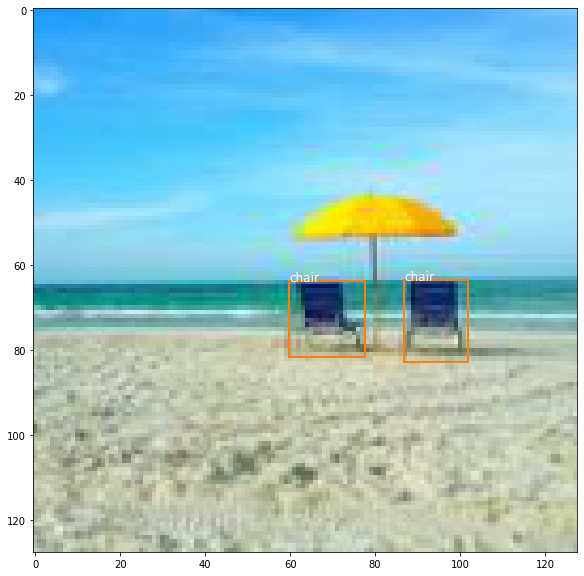

In [ ]:
img_id = train_json['images'][128]['id']
l2bs = stats.img2l2bs[img_id]
img_fname = stats.img2fname[img_id]
img = Image.open(img_dir/img_fname)
overlay_img_bbox(img, l2bs, stats.lbl2name)

## Wrapper Around COCOAPI Metrics

In my initial attempt to port the example code Faster RCNN code to Pytorch-Lightning, I realized soon computing metrics is going to tricky. In fact, I don't actually know even what metrics to use!  Luckily someone pointed me to this well written [article by Raphael Padilla](https://github.com/rafaelpadilla/Object-Detection-Metrics) which explains the metrics used in object detection today. 

The following is my attempt to repurpose [CocoAPI](https://github.com/cocodataset/cocoapi/) which has builtin metric evaluation instead of rolling my own evaluation metrics.  But it was painful as Coco API was not written for easy extension in mind.  For example, it tightly couples JSON file loading (and its format) into metrics computation, so I had to look under the cover for its implementation to then use it in a way that is probably not appropriate.  Also it tighly couple the computation of metrics with the batching of data.

I ended up just writing a wrapper that uses a separate Coco Object for each ground truth and prediction, as if the whole epoch has only 1 sample. 

In [ ]:
# export
def listify(tensorOrIterable):
    return tensorOrIterable.tolist() if type(tensorOrIterable) == torch.Tensor else list(tensorOrIterable)

def tensorify(tensorOrIterable):
    return tensorOrIterable if type(tensorOrIterable) == torch.Tensor else torch.Tensor(tensorOrIterable)

class SubCocoWrapper():
    def __init__(self, prediction, target, width, height):
        # turn tgt: { "boxes": [...], "labels": [...], "image_id": "xxx", "area": [...], "iscrowd": 0 }
        # into COCO with dataset dict of this form:
        # { images: [{'id':int, 'file_name':str, 'width':int, 'height':int}], categories: [int,...], 
        #   annotations: [{'id':int, 'image_id': int, 'category_id': int, 'bbox': (x,y,width,height)}, 'area':float, 'iscrowd':0] }
        # see https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
        
        def toCOCO(rec:dict)->COCO:
            coco = COCO()
            img_id = int(rec.get('image_id', 0)) # could be tensor, cast to int
            coco.dataset['images'] = [ {'id': img_id, 'file_name': f'{img_id:012d}.jpg', 'width': width, 'height': height} ]
            coco.dataset['categories'] = []
            coco.dataset['annotations'] = []
            scores = rec.get('scores',[])
            anno_ids =rec.get('ids',[]) 
            for bi, b in enumerate(listify(rec['boxes'])):
                x, y, w, h = b
                cat_id = int(rec['labels'][bi])
                anno_id = int(anno_ids[bi]) if bi < len(anno_ids) else 0 
                s = float(scores[bi]) if bi < len(scores) else 0.
                coco.dataset["annotations"].append({'id': anno_id, 'image_id': img_id, 'category_id': cat_id, 'bbox': b, 'iscrowd':0, 'area':w*h, 'score':s})
                coco.dataset['categories'].append({'id':cat_id})
                
            coco.createIndex()
            return coco
            
        with io.capture_output() as captured:
            self.target = toCOCO(target)
            self.prediction = toCOCO(prediction)

    def metrics(self)->float:
        with io.capture_output() as captured:
            cocoeval = COCOeval(self.target, self.prediction, "bbox")
            cocoeval.evaluate()
            cocoeval.accumulate()
            cocoeval.summarize()
        return cocoeval.stats

Using the above wrapper, I can then compute the metric for the 1 sample epoch to get the various coco metrics

In [ ]:
#hide

# self to self should be perfect
t0 = {}
t0['labels'] = [1]
t0['ids'] = [9991]
t0['boxes'] = [[0.,0.,5.,5.]]
cocoMAP = SubCocoWrapper(t0, t0, 128, 128).metrics()[0]

print(cocoMAP)

# Perfect prediction should be perfect
p0 = {}
p0['labels'] = [1]
p0['boxes'] = [[0.,0.,5.,5.]]
p0['scores'] = [1.0]
cocoMAP = SubCocoWrapper(p0, t0, 128, 128).metrics()[0]

print(cocoMAP)

# Good prediction should be high but not great
p1 = {}
p1['labels'] = [1]
p1['boxes'] = [[0.,0.,5.2,5.2]]
p1['scores'] = [1.0]
cocoMAP = SubCocoWrapper(p1, t0, 128, 128).metrics()[0]

print(cocoMAP)

# Superfluous predictions should be penalized?
p2 = {}
p2['labels'] = [1, 1]
p2['boxes'] = [[0.,0.,5.2,5.2], [0.2,0.2,5.,5.]]
p2['scores'] = [0.9, 0.9]
cocoMAP = SubCocoWrapper(p2, t0, 128, 128).metrics()[0]

print(cocoMAP)



# target and predictions as tensors

t = {}
t['labels'] = torch.Tensor([1])
t['ids'] = torch.Tensor([9991])
t['boxes'] = torch.Tensor([[0.,0.,5.,5.]])

p = {}
p['labels'] = torch.Tensor([1, 1])
p['boxes'] = torch.Tensor([[0.,0.,5.2,5.2], [0.2,0.2,5.,5.]])
p['scores'] = torch.Tensor([0.9, 0.9])
cocoMAP = SubCocoWrapper(p, t, 128, 128).metrics()[0]

print(cocoMAP)

0.9999999999999998
0.9999999999999998
0.8999999999999999
0.8
0.8


## Alternative Validation Metrics (not affecting training)

Decided to roll my own metrics by the following logic.

* pick all prediction boxes (pbox) with scores above cutoff score (scut) 
* compute all Intersection over Union (IoU) of all pbox and target boxes (tbox), take only pbox and tbox combo of IoU above IoU threshold (ithr)
* for each category C in target
    * true positives (TF): num box (pcat == tcat) above ithr
    * false positives (FP): num box (pcat != tcat) above ithr
    * precision = TP/(TP+FP), recall = TP/(TP+FN) or TP/(num target boxes of C)
    * F1 = 1/(1/prec + 1/recall)
* accuracy = weighted mean by num target boxes of all C's F1 score

In [ ]:
# export
def iou_calc(x1,y1,w1,h1, x2,y2,w2,h2):
    r1 = x1+w1 # right of box1
    b1 = y1+h1 # bottom of box1
    r2 = x2+w2 # right of box2
    b2 = y2+h2 # bottom of box2
    a1 = 1.0*w1*h1
    a2 = 1.0*w2*h2
    ia = 0.0 # intercept
    
    if x1 <= x2 <= r1:
        if y1 <= y2 <= b1 or y1 <= b2 <= b1:
            ia = (min(r1,r2)-max(x1,x2))*(min(b1,b2)-max(y1,y2))
    elif x1 <= r2 <= r1:
        if y1 <= y2 <= b1 or y1 <= b2 <= b1:
            ia = (min(r1,r2)-max(x1,x2))*(min(b1,b2)-max(y1,y2))
    
    #print(a1, a2, ia)
    iou = ia/(a1+a2-ia)
    return iou

Test IoU calc...

In [ ]:
#hide
# All kinds of overlapping rectangles
assert iou_calc(0,0,10,10, 0,0,10,10)==1.0, "Identical rectangles IoU should be 1.0"
assert iou_calc(0,0,10,10, 10,10,10,10)==0.0, "Non overlapping rectangles IoU should be 0.0"
assert (iou:=iou_calc(0,0,10,10, 0,5,10,5))==0.5, f"Expect IoU 0.5 buy got {iou}"
assert (iou:=iou_calc(0,0,10,10, 5,5,10,10))==1/7, f"Expect IoU 1/7 buy got {iou}"
assert (iou:=iou_calc(0,0,1,1, 0,0,10,10))==1/100, f"Expect IoU 1/100 buy got {iou}"
assert (iou:=iou_calc(0,0,10,10, 0,0,1,1))==1/100, f"Expect IoU 1/100 buy got {iou}"
assert (iou:=iou_calc(0,1,10,10, 0,0,10,2))==10/110, f"Expect IoU 10/110 buy got {iou}"
assert (iou:=iou_calc(0,0,10,2, 0,1,10,10))==10/110, f"Expect IoU 10/110 buy got {iou}"
assert (iou:=iou_calc(1,0,10,10, 0,0,2,10))==10/110, f"Expect IoU 10/110 buy got {iou}"
assert (iou:=iou_calc(0,0,2,10, 1,0,10,10))==10/110, f"Expect IoU 10/110 buy got {iou}"
assert (iou:=iou_calc(1,0,2,2, 0,1,2,2))==1/7, f"Expect IoU 1/7 buy got {iou}"
assert (iou:=iou_calc(0,1,2,2, 1,0,2,2))==1/7, f"Expect IoU 1/7 buy got {iou}"

# Non overlapping rectangles
assert (iou:=iou_calc(0,0,1,1, 2,2,1,1))==0/2, f"Expect IoU 0/2 buy got {iou}"
assert (iou:=iou_calc(2,2,1,1, 0,0,1,1))==0/2, f"Expect IoU 0/2 buy got {iou}"
assert (iou:=iou_calc(0,2,1,1, 2,0,1,1))==0/2, f"Expect IoU 0/2 buy got {iou}"
assert (iou:=iou_calc(2,0,1,1, 0,2,1,1))==0/2, f"Expect IoU 0/2 buy got {iou}"

Multicategory multibox matching is messy. How do you pair which target to which prediction?
* 1 target label+box may overlap with multiple predicted label+boxes
* Pick by max IoU area?
* Pick by prefering correct label as long as IoU threshold is met
* After a prediction box is used, need to take it out of rotation for matching next target

Initalize map of labels to 3 counters: True positive, False positive, false Negative ```l2tfn``` 

Find all prediction above confidence score cutoff

for each target box in tboxs
    init maxIoU, maxIndex, maxTrueIou, maxTrueIndex,  to -1, -1, -1, -1
    for each predicted box in pboxs with IoU above threshold
        compare IoU against maxIoU, if more, update maxIoU, maxIndex
        if label match, compare IoU against maxTrueIoU, if more, update maxTrueIoU, maxTrueIndex
    if trueIndex >= 0 update true positive counter under l2tfn, remove pb@maxTrueIndex from pboxs
    else if maxIndex >= 0 update false positive counter under l2tfn, remove pb@maxIndex from pboxs
    if maxIoU < 0 update false negative counter under l2tfn

Count remaining unmatched predictions as False positive of Background.

In [ ]:
#export
def match_true_false_neg(pred, tgt, scut=0.5, ithr=0.5):
    
    #Init map of labels to 3 counters: True positive, False positive, false Negative
    l2tfn = defaultdict(lambda: (0,0,0))
    
    #Find all prediction above confidence score cutoff
    pscores = listify(pred['scores'])
    # original (pscores > scut).nonzero(as_tuple=True) but can't handle non tensor
    pidxs = reduce(lambda l, idx_sc: l+[idx_sc[0]] if idx_sc[1] > scut else l, enumerate(pscores), []) 
    #print(f"pidxs = {pidxs}")
    pboxs = listify(tensorify(pred['boxes'])[pidxs])

    
    tboxs = listify(tgt['boxes'])
    tls = listify(tgt['labels'])
    pls = listify(pred['labels'])
    
    for tl,tb in zip(tls,tboxs):
        #init maxIoU, maxIndex, maxTrueIoU, maxTrueIndex
        maxIoU, maxIndex, maxTrueIoU, maxTrueIndex = -1, -1, -1, -1
        
        x1,y1,w1,h1 = float(tb[0]), float(tb[1]), float(tb[2]), float(tb[3])
        for pi,(pl,pb) in enumerate(zip(pls,pboxs)):
            x2,y2,w2,h2 = float(pb[0]), float(pb[1]), float(pb[2]), float(pb[3])
            iou = iou_calc(x1,y1,w1,h1, x2,y2,w2,h2)
            #ensure IoU above threshold
            if iou < ithr: continue

            if iou > maxIoU: #Found new Max IoU
                maxIoU = iou
                maxIndex = pi
                
            if int(pl)==int(tl) and iou > maxTrueIoU: #Found new Max True IoU
                maxTrueIoU = iou
                maxTrueIndex = pi
        
        if maxTrueIndex >= 0:
            #update true positive counter under l2tfn
            l2tfn[tl] = (l2tfn[tl][0]+1, l2tfn[tl][1], l2tfn[tl][2])
            #remove pb@maxTrueIndex from pboxs
            pls.pop(pi)
            pboxs.pop(pi)
        elif maxIndex >= 0: 
            #update false positive counter under l2tfn
            l2tfn[tl] = (l2tfn[tl][0], l2tfn[tl][1]+1, l2tfn[tl][2])
            #remove pb@maxIndex from pboxs
            pls.pop(pi)
            pboxs.pop(pi)
        else: 
            #update false negative counter under l2tfn
            l2tfn[tl] = (l2tfn[tl][0], l2tfn[tl][1], l2tfn[tl][2]+1)
    
    #Count remaining unmatched predictions as False positive of Background.
    l2tfn[0] = (0, len(pboxs), 0)
    
    return l2tfn

Test this gnarliness

In [ ]:
#hide
tgt = {'labels':[1], 'scores':[1.0], 'boxes':[(0,0,10,10)]}
l2tfn =  match_true_false_neg(tgt, tgt, scut=0.5, ithr=0.5)

assert l2tfn[1] == (1,0,0), f"{tgt} matching itself should get True Positive 1.0 but got {l2tfn}"
assert l2tfn[0] == (0,0,0), f"{tgt} matching itself should have no False Positive but got {l2tfn}"

pred = {'labels':torch.tensor([1]), 'scores':torch.tensor([1.0]), 'boxes':torch.tensor([(0,0,10,10)])}
l2tfn =  match_true_false_neg(pred, tgt, scut=0.5, ithr=0.5)

assert l2tfn[1] == (1,0,0), f"Prediction {pred} matching Target {tgt} should get True Positive 1.0 but got {l2tfn}"
assert l2tfn[0] == (0,0,0), f"Prediction {pred} matching Target {tgt} should have no False Positive but got {l2tfn}"

pred = {'labels':torch.tensor([2]), 'scores':torch.tensor([1.0]), 'boxes':torch.tensor([(0,0,10,10)])}
l2tfn =  match_true_false_neg(pred, tgt, scut=0.5, ithr=0.5)

assert l2tfn[1] == (0,1,0), f"Prediction {pred} matching Target {tgt} should get False Positive 1.0 but got {l2tfn}"
assert l2tfn[0] == (0,0,0), f"Prediction {pred} matching Target {tgt} should have no False Positive but got {l2tfn}"

pred = {'labels':torch.tensor([1]), 'scores':torch.tensor([0.1]), 'boxes':torch.tensor([(0,0,10,10)])}
l2tfn =  match_true_false_neg(pred, tgt, scut=0.5, ithr=0.5)

assert l2tfn[1] == (0,0,1), f"Prediction {pred} matching Target {tgt} right label low confidence should get False Positive 1.0 but got {l2tfn}"
assert l2tfn[0] == (0,0,0), f"Prediction {pred} matching Target {tgt} right label low confidence should have no False Positive but got {l2tfn}"

pred = {'labels':torch.tensor([1]), 'scores':torch.tensor([1.0]), 'boxes':torch.tensor([(0,0,1,1)])}
l2tfn =  match_true_false_neg(pred, tgt, scut=0.5, ithr=0.5)

assert l2tfn[1] == (0,0,1), f"Prediction {pred} matching Target {tgt} right label low IoU should get False Positive 1.0 but got {l2tfn}"
assert l2tfn[0] == (0,1,0), f"Prediction {pred} matching Target {tgt} right label low IoU should have 1 False Positive but got {l2tfn}"

Take average of [F1](https://en.wikipedia.org/wiki/F-score) score for each label weighted by num prediction boxes for each label

In [ ]:
#export
def calc_wavg_F1(pred, tgt, scut=0.5, ithr=0.5):
    l2tfn = match_true_false_neg(pred, tgt, scut=scut, ithr=ithr)
    lset = l2tfn.keys()
    bsum = 0
    l2num = defaultdict(lambda:0)
    for l, (t,f,n) in l2tfn.items(): 
        boxes = t+f+n
        l2num[l]= boxes
        bsum += boxes
        
    l2f1 = {}
    for l in lset:
        tp, fp, fn = l2tfn[l]
        precision = 0 if tp == 0 else tp/(tp+fp)
        recall = 0 if tp == 0 else tp/(tp+fn)
        f1 = 0 if precision*recall == 0 else 2/(1/precision + 1/recall)
        l2f1[l] = f1

    #print(l2tfn, l2f1)
    acc = 0.
    for l, f1 in l2f1.items():
        lnum = l2num[l]
        f1 = l2f1[l]
        acc += f1*(lnum/bsum)

    return acc

Let's test these...

In [ ]:
#hide
tgt = {'labels':[1], 'scores':[1.0], 'boxes':[(0,0,10,10)]}
assert calc_wavg_F1(tgt, tgt) == 1.0, "F1 comparing self to self is 1.0"

pred = {'labels':torch.tensor([0]), 'scores':torch.tensor([1.0]), 'boxes':torch.tensor([(0,0,10,10)])}
assert calc_wavg_F1(pred, tgt) == 0.0, "F1 comparing same box but diff label should be 0.0"

pred = {
    'labels':torch.tensor([1, 2]), 
    'scores':torch.tensor([1.0, 1.0]), 
    'boxes':torch.tensor([(0,0,10,10),(0,0,10,10)])}
assert (acc:=calc_wavg_F1(pred, tgt)) == 1/2, f"F1 same boxes but 1 right 1 wrong label should be 2/3 but got {acc}"

There are Many object detection models to choose from.

To break my anaylysis paralysis researching and deciding between the various models and architectures, I decided to push ahead with what is provided by TorchVision out of the box i.e. Faster R-CNN with pretrained ResNet backbone. 

Luckily there is a turorial to follow
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

First, let's just use the raw model directly and verify the outputs by using raw torchvision model to perform some prediciton to test custom metric function.

In [ ]:
#hide
target = { "boxes": [], "labels": [], "image_id": None, "area": [], "iscrowd": 0, "ids": [] }
count = 0
lbs = stats.img2lbs.get(img_id,[])
for l, x, y, w, h in lbs:
    count += 1
    target["boxes"].append([x, y, x+w, y+h]) # FRCNN wants x1,y1,x2,y2 format!
    target["labels"].append(l)
    target["image_id"] = img_id
    target["area"].append(w*h)
    anno_id = img_id*1000 + count
    target["ids"].append(anno_id)

for k, v in target.items():
    target[k] = torch.tensor(v)
    
images = [transforms.ToTensor()(img)]
targets = [target]

# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    frcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    for param in frcnn_model.parameters():
        param.requires_grad = False
    in_features = frcnn_model.roi_heads.box_predictor.cls_score.in_features
    frcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, stats.num_cats+1) # to account for 0:backgrnd

    # how to get both in 1 step?
    frcnn_model.train()
    losses = frcnn_model(images,targets) 
    print(f"Losses of untrained Model is {losses}")
    frcnn_model.eval()
    predict = frcnn_model(images)[0]
    acc = calc_wavg_F1(predict, target, .1, .1)
    print(f"Prediction of untrained Model is {predict}, Accuracy of untrained Model is {acc}")

/usr/local/lib/python3.8/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Losses of untrained Model is {'loss_classifier': tensor(2.4630, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.2732, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0128), 'loss_rpn_box_reg': tensor(0.0024)}
Prediction of untrained Model is {'boxes': tensor([[7.2332e+01, 4.3231e+01, 9.4826e+01, 5.1803e+01],
        [7.0616e+01, 4.1712e+01, 9.6135e+01, 4.8171e+01],
        [6.9593e+01, 4.1484e+01, 8.7241e+01, 6.1411e+01],
        [7.5919e+01, 3.9999e+01, 9.3052e+01, 6.0132e+01],
        [8.4360e+01, 4.2527e+01, 9.9615e+01, 5.2179e+01],
        [6.3072e+01, 4.3160e+01, 8.4846e+01, 5.2245e+01],
        [7.9567e+01, 4.0946e+01, 9.9012e+01, 5.6191e+01],
        [6.3438e+01, 4.0449e+01, 8.6576e+01, 7.1725e+01],
        [6.5400e+01, 4.0124e+01, 9.4182e+01, 5.4678e+01],
        [5.7006e+01, 4.2083e+01, 8.2488e+01, 6.3189e+01],
        [5.9646e+01, 3.7877e+01, 7.9622e+01, 5.4484e+01],
        [7.4922e+01, 3.4759e+01, 8.9759e+01, 5.3547e+01],
        [7.1007e+01, 4.1806e+01, 9.9069e+0

We've tested using Pytorch Lightning to save and load pretrained model but found [bug](https://github.com/PyTorchLightning/pytorch-lightning/issues/2550).

## Utility for Inference

In [ ]:
#export
def digest_pred(l2name, pred, cutoff=0.5):
    scores = pred['scores']
    pass_idxs = (scores > cutoff).nonzero(as_tuple=False)
    lbls = pred['labels'][pass_idxs]
    bboxs = pred['boxes'][pass_idxs]
    l2bs = defaultdict(lambda: [])
    for l, b in zip(lbls, bboxs):
        x,y,w,h = b[0]
        n = l2name[l.item()]
        bs = l2bs[l.item()]
        bs.append((x.item(),y.item(),w.item(),h.item()))
    return l2bs

Prediction is going to be garbage since we only train for 1 epoch but just want to make sure whole pipeline doesn't bomb.

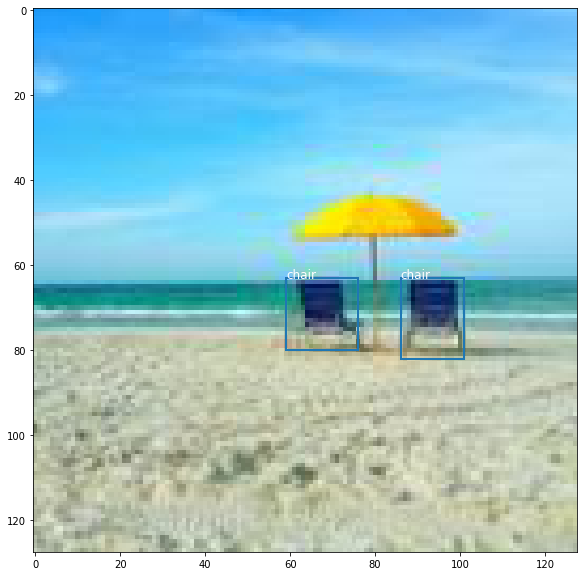

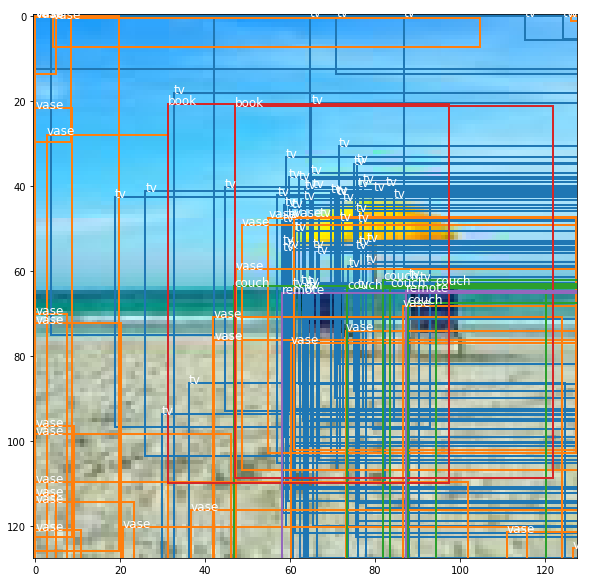

In [ ]:
#hide
x, y = images[0], targets[0]
pimg = torchvision.transforms.ToPILImage()(x)
tgt_l2bs = defaultdict(empty_list)
for l, b in zip(list(y['labels']), y['boxes']):
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 
           
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)


# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    pred_l2bs = digest_pred(stats.lbl2name, predict, cutoff=0.1)
    overlay_img_bbox(pimg, pred_l2bs, stats.lbl2name)

Verify saving model and loading works using underlying Pytorch.

## Export to Regular Python Script as 'subcoco_utils.py'

In [ ]:
#hide
from nbdev.export import *
notebook2script(fname='10_subcoco_utils.ipynb')

Converted 10_subcoco_utils.ipynb.
